# 🌧️ Project 2.0: Rainfall/Drought Forecasting

**Goal:** Utilize Time Series Analysis (e.g., ARIMA, Prophet, or LSTMs) to forecast future rainfall patterns, providing essential predictive input for the Water Quality Model and supporting drought early warning systems.

**Owner:** Jetty AI Lab

## 🛠️ Notebook Series Plan

| Step | Description | Status |
| :--- | :--- | :--- |
| **2.0** | **Data Acquisition & Cleaning** | Current |
| **2.1** | **Exploratory Data Analysis (EDA)** | Next |
| **2.2** | **Time Series Decomposition & Stationarity Check** | To Do |
| **2.3** | **Model Training (Prophet / ARIMA / LSTM)** | To Do |
| **2.4** | **Model Evaluation & Forecasting** | To Do |

## 📁 Data Source & Structure

**Source:** Historical Meteorological Data (Rainfall Readings)

| Column Name | Data Type | Description |
| :--- | :--- | :--- |
| **Date** | Datetime | The timestamp for the rainfall reading. **(Will be set as the index)** |
| **Rainfall_mm** | Float | The measured rainfall in millimeters (the target variable for forecasting). |

In [37]:
import pandas as pd
import numpy as np

# 1. Load Raw Data (Re-run from the last successful point)
data_path = '~/jetty-ai-lab/projects/water-climate/data/raw/rainfall_data.csv'

try:
    # Read the data
    df_raw = pd.read_csv(data_path)
    
    # 2. Create a Datetime Column and Index (Cleanup)
    # Combine the three columns into a single datetime object
    df_raw['Date'] = pd.to_datetime(df_raw[['Year', 'Month', 'Day']])
    
    # Set the Date as the index
    df_raw.set_index('Date', inplace=True)
    
    # 3. Select Only the Target Variable and Rename
    # We isolate the 'Precipitation' column (our target) and rename it for clarity.
    df_ts = df_raw[['Precipitation']].copy()
    df_ts.rename(columns={'Precipitation': 'Rainfall_mm'}, inplace=True)
    
    # 4. Final Review
    print("✅ Time Series Data Ready. Initial 5 rows:")
    print(df_ts.head())
    print("\nFinal Data Info:")
    df_ts.info()

except FileNotFoundError:
    print(f"❌ Error: Data file not found at {data_path}. Please check the filename and path.")
except KeyError as e:
    # This catches errors if 'Year', 'Month', 'Day', or 'Precipitation' were changed.
    print(f"❌ Error: A required column was not found in the CSV: {e}")
    

✅ Time Series Data Ready. Initial 5 rows:
            Rainfall_mm
Date                   
2000-01-01         0.00
2000-02-01         0.11
2000-03-01         0.01
2000-04-01         0.02
2000-05-01       271.14

Final Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2000-01-01 to 2020-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Rainfall_mm  252 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


In [38]:
# Save the cleaned time series data to the processed folder
output_path = '~/jetty-ai-lab/projects/water-climate/data/processed/rainfall_timeseries.csv'
df_ts.to_csv(output_path)
print(f"✅ Cleaned time series data saved to: {output_path}")

✅ Cleaned time series data saved to: ~/jetty-ai-lab/projects/water-climate/data/processed/rainfall_timeseries.csv


In [39]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    # Perform the ADF test
    result = adfuller(series.dropna())
    
    # Extract and display key results
    print('Augmented Dickey-Fuller Test Results:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    
    # Interpretation
    # H0 (Null Hypothesis) is that the time series is NOT stationary.
    if result[1] <= 0.05:
        print("\nConclusion: 🟢 REJECT H0. The time series is LIKELY stationary.")
    else:
        print("\nConclusion: 🔴 FAIL TO REJECT H0. The time series is NON-STATIONARY.")

# Run the test on your rainfall data
adf_test(df_ts['Rainfall_mm'])

Augmented Dickey-Fuller Test Results:
ADF Statistic: -2.4663
p-value: 0.1239
Critical Values:
	1%: -3.4580
	5%: -2.8737
	10%: -2.5733

Conclusion: 🔴 FAIL TO REJECT H0. The time series is NON-STATIONARY.


In [40]:
import pandas as pd
from prophet import Prophet

# 1. Data Persistence (Saving)
output_path = '~/jetty-ai-lab/projects/water-climate/data/processed/rainfall_timeseries1.csv'
df_ts.to_csv(output_path)
print(f"✅ Cleaned time series data saved to: {output_path}")

# --- PROPHET MODELING ---

# 2. Prepare Data: Reset index and rename columns
# The df_ts variable is defined from the previous successful loading cell
df_prophet = df_ts.reset_index().rename(columns={'Date': 'ds', 'Rainfall_mm': 'y'})

# 3. Initialize and Fit the Model
# Prophet is designed to handle strong monthly/annual seasonality by default
model = Prophet(interval_width=0.95)
model.fit(df_prophet)

print("✅ Prophet Model Trained Successfully!")


17:10:48 - cmdstanpy - INFO - Chain [1] start processing


✅ Cleaned time series data saved to: ~/jetty-ai-lab/projects/water-climate/data/processed/rainfall_timeseries1.csv


17:10:48 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet Model Trained Successfully!


✅ Future Dates Created (Last 5 rows):
            ds
265 2022-02-01
266 2022-03-01
267 2022-04-01
268 2022-05-01
269 2022-06-01

✅ Forecast Generated (Last 5 predictions):
            ds        yhat  yhat_lower  yhat_upper
265 2022-02-01   35.570889 -244.904719  301.477673
266 2022-03-01   34.067378 -264.663983  314.086013
267 2022-04-01   33.508280 -244.568446  326.707744
268 2022-05-01   67.701014 -193.182097  335.121300
269 2022-06-01  566.739008  284.707315  850.983773


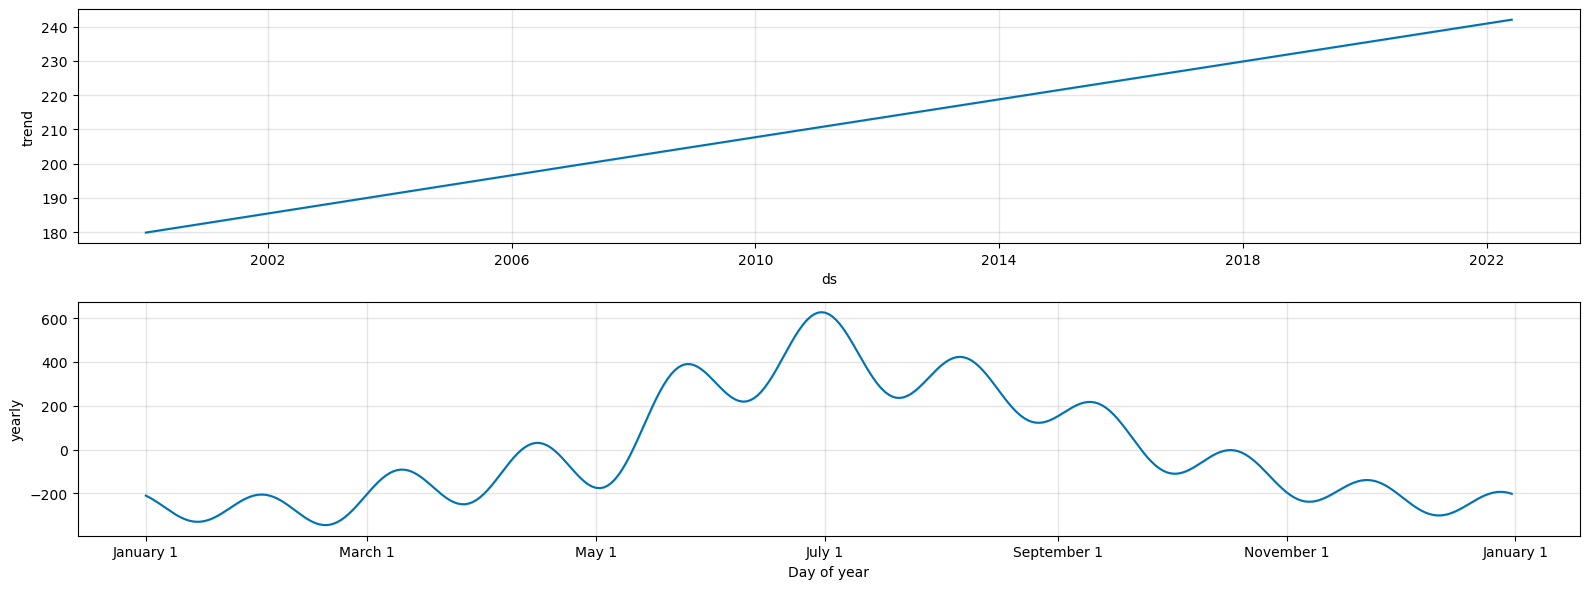

In [41]:
# 1. Create Future Dates (Forecast Horizon)
future = model.make_future_dataframe(periods=18, freq='MS')
print("✅ Future Dates Created (Last 5 rows):")
print(future.tail())

# 2. Generate the Forecast
forecast = model.predict(future)
print("\n✅ Forecast Generated (Last 5 predictions):")
# yhat is the predicted value
# yhat_lower and yhat_upper define the 95% uncertainty interval
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# 3. Visualize the Results
# Plot the forecast components to analyze the pattern
fig2 = model.plot_components(forecast, figsize=(16, 6))
plt.show()

In [42]:
import matplotlib.pyplot as plt

In [43]:
import pickle
import sys

# Define the relative path to the MLOps models directory
# The model file will be saved as prophet_rainfall_model.pkl
model_path = '~/jetty-ai-lab/projects/water-climate/models'

# Serialize (save) the trained model object using the 'wb' (write binary) mode
try:
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"✅ Trained Prophet Model successfully serialized and saved to: {model_path}")
    
except NameError:
    # This catches the error if 'model' was not defined (i.e., the training cell was skipped)
    print("❌ Error: 'model' is not defined. Please rerun the model training cell first.")
except FileNotFoundError:
    # This catches an error if the path is fundamentally wrong
    print(f"❌ Error: Directory not found. Check if the 'models' folder exists at: {model_path}")

# --- CONCLUSION ---
print("\n🎉 PHASE 2 NOTEBOOK COMPLETE: Data cleaned, model trained, and saved.")

❌ Error: Directory not found. Check if the 'models' folder exists at: ~/jetty-ai-lab/projects/water-climate/models

🎉 PHASE 2 NOTEBOOK COMPLETE: Data cleaned, model trained, and saved.
